In [1]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/data/'

# Xác định đường dẫn tới dữ liệu
celeba_test_path = f"{base_path}AvatarAnime/CelebA/test"
anime_test_path = f"{base_path}AvatarAnime/AnimeFace/test"

print(f"CelebA test path: {celeba_test_path}")
# Kiểm tra xem thư mục có tồn tại không
import os
if not os.path.exists(celeba_test_path):
    print(f"LỖI: Đường dẫn '{celeba_test_path}' không tồn tại. Hãy kiểm tra lại biến `base_path`!")
else:
    print("Tìm thấy thư mục CelebA/test.")

Mounted at /content/drive
CelebA test path: /content/drive/MyDrive/data/AvatarAnime/CelebA/test
Tìm thấy thư mục CelebA/test.


In [2]:
!pip install -q diffusers transformers accelerate PilloW opencv-python-headless controlnet_aux matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.2 MB/s eta 0:00:00


In [ ]:
import torch
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
from controlnet_aux import CannyDetector # Sử dụng Canny edge làm ví dụ
from PIL import Image
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# --- Chọn thiết bị ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Tải ControlNet Model (Canny) ---
# Có thể thử các controlnet khác bằng cách thay đổi tên checkpoint
# Ví dụ: 'lllyasviel/sd-controlnet-openpose', 'lllyasviel/sd-controlnet-depth'
controlnet_id = "lllyasviel/sd-controlnet-canny"
print(f"Loading ControlNet model: {controlnet_id}")
controlnet = ControlNetModel.from_pretrained(controlnet_id, torch_dtype=torch.float16)
print("ControlNet model loaded.")

# --- Tải Stable Diffusion Pipeline với ControlNet ---
# Sử dụng base Stable Diffusion v1.5.
# Có thể thử các checkpoint SD khác (kể cả các checkpoint đã fine-tune cho anime)
# Ví dụ: "runwayml/stable-diffusion-v1-5", "emilianJR/AnythinV4.0", "hakurei/waifu-diffusion" (cần kiểm tra license)
stable_diffusion_id = "runwayml/stable-diffusion-v1-5"
print(f"Loading Stable Diffusion pipeline with ControlNet support: {stable_diffusion_id}")
# Tải pipeline Img2Img với ControlNet support
# Đảm bảo dùng cùng checkpoint SD và ControlNet đã chọn
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    stable_diffusion_id, # Ví dụ: "runwayml/stable-diffusion-v1-5"
    controlnet=controlnet,
    torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()
pipe.to(device)
print("Img2Img Pipeline ready.")

# --- Tải bộ tiền xử lý Canny ---
canny_detector = CannyDetector()
print("Canny detector ready.")

Using device: cuda
Loading ControlNet model: lllyasviel/sd-controlnet-canny
ControlNet model loaded.
Loading Stable Diffusion pipeline with ControlNet support: runwayml/stable-diffusion-v1-5


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Img2Img Pipeline ready.
Canny detector ready.


095629.jpg
Processing image: /content/drive/MyDrive/data/AvatarAnime/sdc3.jpg
Original image size: (1280, 1280)
Resized input image to: (512, 512)
Generated Canny edge map size: (512, 512)


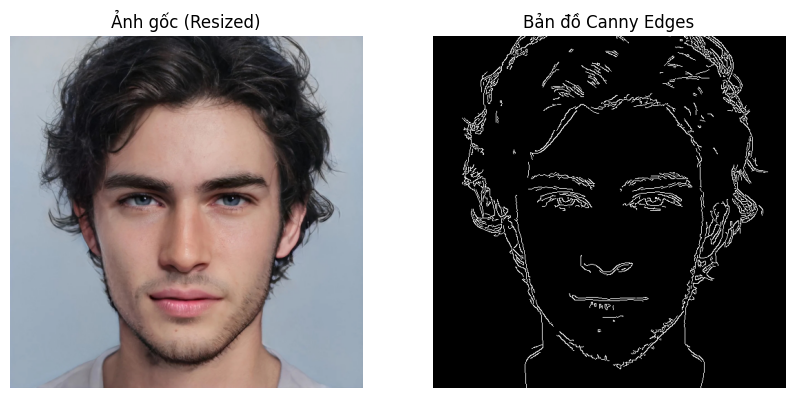

In [ ]:
# --- Chọn ảnh đầu vào ---
try:
    image_files = [f for f in os.listdir(celeba_test_path) if os.path.isfile(os.path.join(celeba_test_path, f))]
    if not image_files:
        raise FileNotFoundError("Không tìm thấy file ảnh nào trong thư mục CelebA/test.")

    random_image_name = random.choice(image_files)
    print(random_image_name)
    # input_image_path = os.path.join(celeba_test_path, random_image_name)
    input_image_path = os.path.join(base_path, "AvatarAnime/sdc3.jpg")
    print(f"Processing image: {input_image_path}")

    # --- Đọc ảnh gốc ---
    # Ảnh đã được resize 128x128, nhưng SD thường hoạt động tốt hơn ở 512x512.
    # resize lại ảnh gốc và control map lên 512x512 để có kết quả tốt hơn.
    # Nếu muốn giữ 128x128, hãy thay đổi `target_size` và kiểm tra kết quả.
    target_size = 512
    input_image_pil = load_image(input_image_path) # load_image trả về PIL Image
    print(f"Original image size: {input_image_pil.size}")
    input_image_pil = input_image_pil.resize((target_size, target_size))
    print(f"Resized input image to: {input_image_pil.size}")

    # Chuyển PIL Image sang Numpy array để Canny xử lý
    input_image_np = np.array(input_image_pil)

    # --- Tạo Control Map (Canny Edges) ---
    # Detect Canny edges
    # Có thể điều chỉnh low_threshold và high_threshold để thay đổi chi tiết của Canny map
    low_threshold = 100
    high_threshold = 200
    canny_image_np = canny_detector(input_image_np, low_threshold, high_threshold)

    # Chuyển Numpy Canny map (có thể là 2D) thành PIL Image (3 channel)
    canny_image_pil = Image.fromarray(canny_image_np)
    print(f"Generated Canny edge map size: {canny_image_pil.size}")

    # Hiển thị ảnh gốc và Canny map
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_image_pil)
    axes[0].set_title('Ảnh gốc (Resized)')
    axes[0].axis('off')

    axes[1].imshow(canny_image_pil, cmap='gray')
    axes[1].set_title('Bản đồ Canny Edges')
    axes[1].axis('off')

    plt.show()

except FileNotFoundError as e:
    print(f"LỖI: {e}")
    print("Hãy chắc chắn rằng đường dẫn tới thư mục CelebA/test là chính xác và có chứa ảnh.")
except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")
    # Giải phóng bộ nhớ GPU nếu có lỗi
    import gc
    gc.collect()
    torch.cuda.empty_cache()

Using seed: 320858, Strength: 0.5
Generating image using Img2Img pipeline...


  0%|          | 0/15 [00:00<?, ?it/s]

Image generation complete.


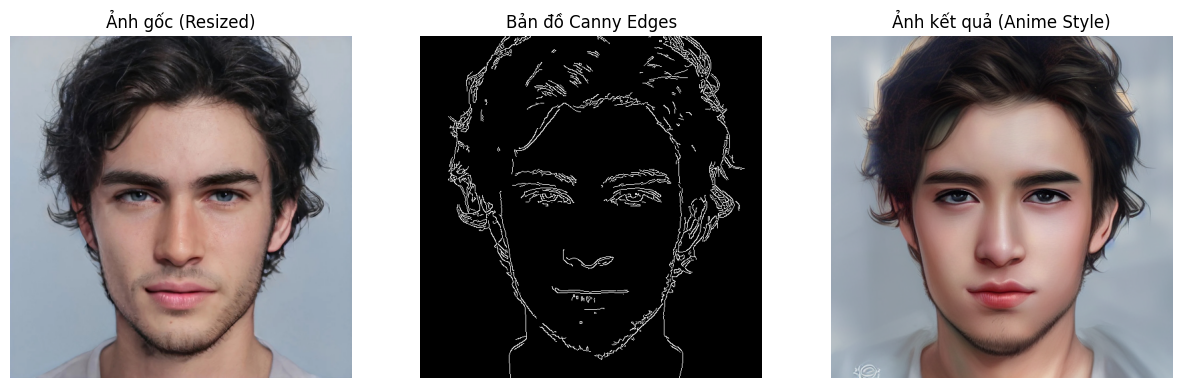

GPU memory cache cleared.


In [17]:
# --- Định nghĩa Prompt và Tham số ---
prompt = "anime style portrait, masterpiece, best quality, sharp focus, detailed illustration, 1boy"
negative_prompt = "photorealistic, real photo, low quality, blurry, noisy, text, watermark, signature, ugly, deformed, multiple heads, extra limbs"
generator_seed = random.randint(0, 1000000)
generator = torch.Generator(device=device).manual_seed(generator_seed)
num_inference_steps = 30
guidance_scale = 9.0
controlnet_conditioning_scale = 0.8 # Vẫn cần thiết

# <<< THAM SỐ MỚI QUAN TRỌNG >>>
image_strength = 0.5 # <<< THỬ NGHIỆM GIÁ TRỊ NÀY (ví dụ: 0.6, 0.7, 0.8)

print(f"Using seed: {generator_seed}, Strength: {image_strength}")
print("Generating image using Img2Img pipeline...")

try:
    # Chạy pipeline Img2Img
    output_image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=input_image_pil, # <<< Ảnh gốc được resize
        control_image=canny_image_pil, # <<< Control map (Canny)
        strength=image_strength, # <<< Mức độ thay đổi so với ảnh gốc
        num_inference_steps=num_inference_steps,
        generator=generator,
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
    ).images[0]

    print("Image generation complete.")

    # --- Hiển thị kết quả ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_image_pil)
    axes[0].set_title('Ảnh gốc (Resized)')
    axes[0].axis('off')

    axes[1].imshow(canny_image_pil, cmap='gray')
    axes[1].set_title('Bản đồ Canny Edges')
    axes[1].axis('off')

    axes[2].imshow(output_image)
    axes[2].set_title('Ảnh kết quả (Anime Style)')
    axes[2].axis('off')

    plt.show()

    # Lưu ảnh kết quả (tùy chọn)
    # output_image.save(f"{base_path}output_anime_{random_image_name}.png")
    # print(f"Result saved to {base_path}output_anime_{random_image_name}.png")

except Exception as e:
    print(f"Đã xảy ra lỗi trong quá trình tạo ảnh: {e}")
finally:
    # Giải phóng bộ nhớ GPU sau khi chạy
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU memory cache cleared.")